In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# 기본 경로 설정
BASE_DIR = "F:/박정현/ML"
MODEL_BASE_PATH = os.path.join(BASE_DIR, "machine_learning_project/final_2024")

# 사용자가 지정할📌 특정 경관 요소 (예: "ld0", "ld1", "ld2" ...)
LANDSCAPE  = "ld1"  
# 사용할 모델 리스트 (4개 모델)
model_names = ["lgbm", "xgb", "rf", "gb"]

# 각 모델의 개별 경로 설정
MODEL_PATHS = {model_name: os.path.join(MODEL_BASE_PATH, LANDSCAPE, f"{model_name}.pkl") for model_name in model_names}

print("🔹 모델 경로 설정 완료")
for model_name, path in MODEL_PATHS.items():
    print(f"{model_name.upper()} 모델 경로: {path}")

# 모델 색상 설정
model_colors = {
    "lgbm": "green",
    "xgb": "red",
    "rf": "blue",
    "gb": "orange"
}

# 모델 풀네임 설정
model_full_names = {
    "lgbm": "Light Gradient Boosting",
    "xgb": "Extreme Gradient Boosting",
    "rf": "Random Forest",
    "gb": "Gradient Boosting"
}

# 데이터 로드
DATA_PATH = os.path.join(BASE_DIR, "machine_learning_project/data/weather/2015_2024_total.xlsx")
df = pd.read_excel(DATA_PATH, engine="openpyxl")
df["DATE"] = pd.to_datetime(df["DATE"])

print("🔹 데이터 로드 완료")
print(f"📌 원본 데이터 크기: {df.shape}")



🔹 모델 경로 설정 완료
📌 LGBM 모델 경로: F:/박정현/ML\machine_learning_project/final_2024\ld1\lgbm.pkl
📌 XGB 모델 경로: F:/박정현/ML\machine_learning_project/final_2024\ld1\xgb.pkl
📌 RF 모델 경로: F:/박정현/ML\machine_learning_project/final_2024\ld1\rf.pkl
📌 GB 모델 경로: F:/박정현/ML\machine_learning_project/final_2024\ld1\gb.pkl
🔹 데이터 로드 완료
📌 원본 데이터 크기: (78909, 21)


In [2]:
# 경관 요소 필터링 함수
def filter_by_landscape(df, landscape):
    """경관요소 필터링"""
    # LANDSCAPE 값이 문자열("ld0", "ld1" ...)이면 숫자로 변환
    landscape_mapping = {"ld0": 0, "ld1": 1, "ld2": 2, "ld3": 3}
    
    if landscape in landscape_mapping:
        landscape_value = landscape_mapping[landscape]
        df = df[df["landscape"] == landscape_value]
        print(f"✅ 경관요소 {landscape} ({landscape_value}) 선택 완료, 데이터 크기: {df.shape}")
    else:
        print("✅ 전체 데이터 사용")

    return df

# 📌 경관요소 선택 적용
df = filter_by_landscape(df, LANDSCAPE)

✅ 경관요소 ld1 (1) 선택 완료, 데이터 크기: (9542, 21)


In [3]:
import joblib
import os

# 모델별 Feature 목록 저장 경로
feature_paths = {model_name: os.path.join(MODEL_BASE_PATH, LANDSCAPE, f"{model_name}.pkl") for model_name in model_names}

# 모델별 Feature 목록 불러오기
saved_features = {}
for model_name, path in feature_paths.items():
    if os.path.exists(path):
        model = joblib.load(path)  # 모델 로드

        # LightGBM/XGBoost 모델의 경우
        if hasattr(model, "booster_"):  
            saved_features[model_name] = model.booster_.feature_name()
        
        # XGBoost 모델의 경우
        elif "XGB" in str(type(model)):  
            saved_features[model_name] = model.get_booster().feature_names
        
        # RandomForest, GradientBoosting 모델의 경우
        elif hasattr(model, "feature_names_in_"):  
            saved_features[model_name] = list(model.feature_names_in_)
        
        else:
            print(f"⚠️ {model_name} 모델에서 Feature 목록을 가져올 수 없음.")
            saved_features[model_name] = None
        
        print(f"✅ {model_name} 모델 학습 시 사용한 Feature 개수: {len(saved_features[model_name])}")
    else:
        print(f"⚠️ {model_name} 모델의 저장된 Feature 목록이 없음.")
        saved_features[model_name] = None  # 이후 예외 처리 필요



✅ lgbm 모델 학습 시 사용한 Feature 개수: 36
✅ xgb 모델 학습 시 사용한 Feature 개수: 36
✅ rf 모델 학습 시 사용한 Feature 개수: 36
✅ gb 모델 학습 시 사용한 Feature 개수: 36


In [4]:
print("📌 저장된 Feature 목록 확인:")
for model_name, features in saved_features.items():
    print(f"{model_name}: {features if features else '❌ 없음'}")


📌 저장된 Feature 목록 확인:
lgbm: ['TMAX', 'TMIN', 'PCP', 'HUM', 'WS', 'Temp_1_monthly_mean', 'Temp_1_yearly_mean', 'DMS_open_1m', 'DMS_open_3m', 'DMS_open_5m', 'DMS_open_10m', 'Env_Factors_1m', 'Env_Factors_3m', 'Env_Factors_5m', 'Env_Factors_10m', 'mosquito_rolling1', 'mosquito_rolling2', 'mosquito_rolling3', 'mosquito_rolling4', 'mosquito_rolling5', 'mosquito_rolling6', 'mosquito_rolling7', 'mosquito_rolling8', 'mosquito_rolling9', 'mosquito_rolling10', 'mosquito_rolling11', 'mosquito_rolling12', 'mosquito_rolling13', 'mosquito_rolling14', 'mosquito_rolling15', 'mosquito_rolling16', 'mosquito_rolling17', 'mosquito_rolling18', 'mosquito_rolling19', 'mosquito_rolling20', 'mosquito_rolling21']
xgb: ['TMAX', 'TMIN', 'PCP', 'HUM', 'WS', 'Temp_1_monthly_mean', 'Temp_1_yearly_mean', 'DMS_open_1m', 'DMS_open_3m', 'DMS_open_5m', 'DMS_open_10m', 'Env_Factors_1m', 'Env_Factors_3m', 'Env_Factors_5m', 'Env_Factors_10m', 'mosquito_rolling1', 'mosquito_rolling2', 'mosquito_rolling3', 'mosquito_rolling4',

In [5]:
def processed_data(df, model_name):
    """모기 개체 수 데이터를 전처리하고 모델 학습 시 사용한 Feature 개수와 일치시킴"""

    # 이상치 제거 (1.5 * IQR)
    Q1 = df['mosquito'].quantile(0.25)
    Q3 = df['mosquito'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df['mosquito'] >= lower_bound) & (df['mosquito'] <= upper_bound)]

    # 롤링 피처 추가 (과거 21일 데이터)
    df_filtered = df_filtered.copy()
    df_grouped = df_filtered.groupby('DMS_CODE')
    for i in range(1, 22):
        df_filtered[f'mosquito_rolling{i}'] = df_grouped['mosquito'].shift(i)
    
    # 결측치 제거
    df_filtered.dropna(inplace=True)

    # Train-Test 데이터 분리
    df_filtered["Year"] = pd.to_datetime(df_filtered["DATE"]).dt.year
    TEST_YEAR = 2024
    train_data = df_filtered[df_filtered["Year"] < TEST_YEAR]
    test_data = df_filtered[df_filtered["Year"] >= TEST_YEAR]

    # 모델별 Feature 목록 적용
    if model_name in saved_features and saved_features[model_name] is not None:
        feature_columns = [col for col in saved_features[model_name] if col in train_data.columns]
        print(f"{model_name} 모델과 동일한 Feature 개수 사용: {len(feature_columns)}")
    else:
        feature_columns = train_data.select_dtypes(include=[np.number]).columns.difference(["mosquito"])
        print(f"{model_name} 모델의 저장된 Feature 목록 없음. 현재 Feature 개수: {len(feature_columns)}")

    # Feature 순서 일치시키기 (saved_features가 있는 경우에만 적용)
    if model_name in saved_features and saved_features[model_name] is not None:
        feature_columns = sorted(feature_columns, key=lambda x: saved_features[model_name].index(x) if x in saved_features[model_name] else len(saved_features[model_name]))

    # X, y 분리 (필요한 Feature만 사용)
    X_train = train_data[feature_columns]
    y_train = train_data['mosquito']
    X_test = test_data[feature_columns]
    y_test = test_data['mosquito']

    # 스케일링
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                                  columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                                 columns=X_test.columns, index=X_test.index)

    print(f"{model_name} 모델의 Feature 개수 일치 여부 확인: X_train_scaled({X_train_scaled.shape[1]}), X_test_scaled({X_test_scaled.shape[1]})")

    return scaler, X_train_scaled, X_test_scaled, y_train, y_test, train_data, test_data

# 모델별 데이터 전처리 수행
processed_results = {}
for model_name in model_names:
    print(f"{model_name} 모델에 맞는 Feature 개수로 데이터 전처리 중...")
    processed_results[model_name] = processed_data(df, model_name)
# 모델별 예측값 저장
predictions = {}
y_pred_avg = {}

lgbm 모델에 맞는 Feature 개수로 데이터 전처리 중...
lgbm 모델과 동일한 Feature 개수 사용: 36
lgbm 모델의 Feature 개수 일치 여부 확인: X_train_scaled(36), X_test_scaled(36)
xgb 모델에 맞는 Feature 개수로 데이터 전처리 중...
xgb 모델과 동일한 Feature 개수 사용: 36
xgb 모델의 Feature 개수 일치 여부 확인: X_train_scaled(36), X_test_scaled(36)
rf 모델에 맞는 Feature 개수로 데이터 전처리 중...
rf 모델과 동일한 Feature 개수 사용: 36
rf 모델의 Feature 개수 일치 여부 확인: X_train_scaled(36), X_test_scaled(36)
gb 모델에 맞는 Feature 개수로 데이터 전처리 중...
gb 모델과 동일한 Feature 개수 사용: 36
gb 모델의 Feature 개수 일치 여부 확인: X_train_scaled(36), X_test_scaled(36)


In [6]:
for model_name in model_names:
    model_path = MODEL_PATHS[model_name]

    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"{model_full_names[model_name]} 모델 로드 완료!")

        # 모델에 맞는 데이터 가져오기
        scaler, X_train_scaled, X_test_scaled, y_train, y_test, train_data, test_data = processed_results[model_name]

        # 예측 수행 (Train & Test)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        # 평가 지표 계산 (Train & Test)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        print(f"{model_full_names[model_name]} 평가 완료:")
        print(f"   Train R²: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}")
        print(f"   Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}")

        # 예측값을 DataFrame으로 변환 및 월-일 단위 평균 계산
        y_pred_df = pd.DataFrame({"DATE": test_data["DATE"], "Prediction": y_test_pred})
        y_pred_df["Month"] = y_pred_df["DATE"].dt.month
        y_pred_df["Day"] = y_pred_df["DATE"].dt.day
        y_pred_avg[model_name] = y_pred_df.groupby(["Month", "Day"])["Prediction"].mean().reset_index()
        y_pred_avg[model_name]["Date"] = pd.to_datetime(y_pred_avg[model_name][["Month", "Day"]].assign(Year=2024))
        y_pred_avg[model_name].set_index("Date", inplace=True)

        # 예측값 저장
        predictions[model_name] = {
            "y_pred": y_test_pred,
            "train_r2": train_r2,
            "test_r2": test_r2,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse
        }
    else:
        print(f"{model_full_names[model_name]} 모델 파일이 존재하지 않습니다: {model_path}")

print("모든 모델의 예측 완료 및 평가 지표 저장 완료")

Light Gradient Boosting 모델 로드 완료!
Light Gradient Boosting 평가 완료:
   Train R²: 0.7967, Train RMSE: 32.6451
   Test R²: 0.8008, Test RMSE: 23.5209
Extreme Gradient Boosting 모델 로드 완료!
Extreme Gradient Boosting 평가 완료:
   Train R²: 0.7847, Train RMSE: 33.5940
   Test R²: 0.8047, Test RMSE: 23.2887
Random Forest 모델 로드 완료!
Random Forest 평가 완료:
   Train R²: 0.8611, Train RMSE: 26.9780
   Test R²: 0.7937, Test RMSE: 23.9385
Gradient Boosting 모델 로드 완료!
Gradient Boosting 평가 완료:
   Train R²: 0.8003, Train RMSE: 32.3538
   Test R²: 0.8034, Test RMSE: 23.3662
모든 모델의 예측 완료 및 평가 지표 저장 완료


In [7]:
# 📌 (월, 일) 단위 평균 데이터 계산 추가
test_data["Month"] = test_data["DATE"].dt.month
test_data["Day"] = test_data["DATE"].dt.day

# 📌 실제 모기 개체 수 (Observation) 평균 계산
test_data_avg = test_data.groupby(["Month", "Day"])["mosquito"].mean().reset_index()
test_data_avg["Date"] = pd.to_datetime(test_data_avg[["Month", "Day"]].assign(Year=2024))
test_data_avg.set_index("Date", inplace=True)

print("📌 test_data_avg 생성 완료")
print(test_data_avg.head())


📌 test_data_avg 생성 완료
            Month  Day  mosquito
Date                            
2024-04-02      4    2       4.4
2024-04-03      4    3       7.6
2024-04-04      4    4       5.8
2024-04-05      4    5       5.6
2024-04-06      4    6      10.4


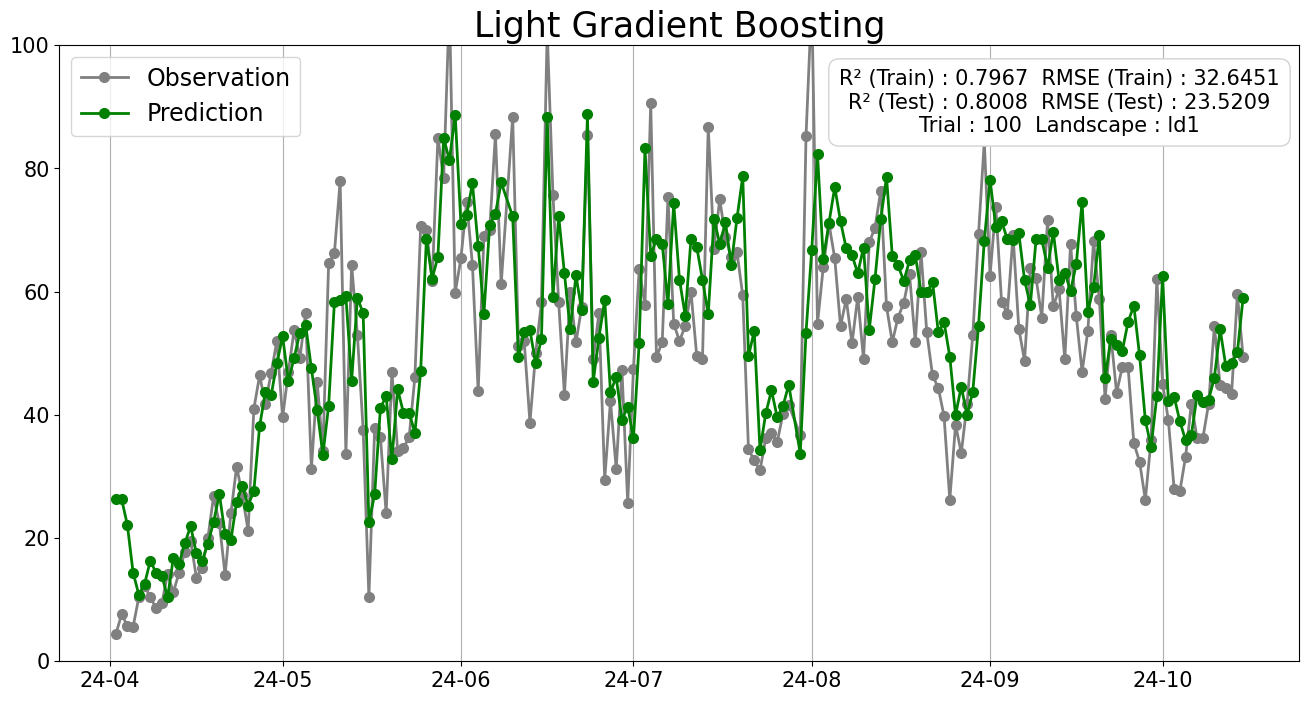

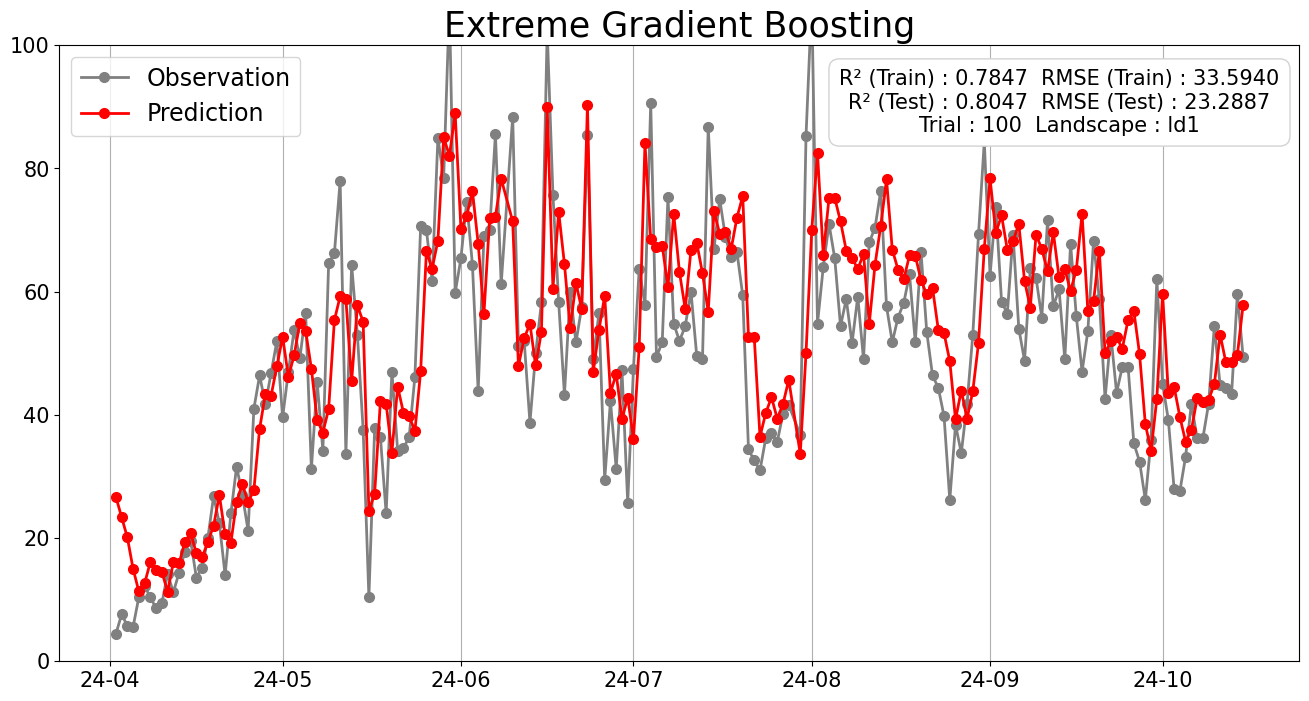

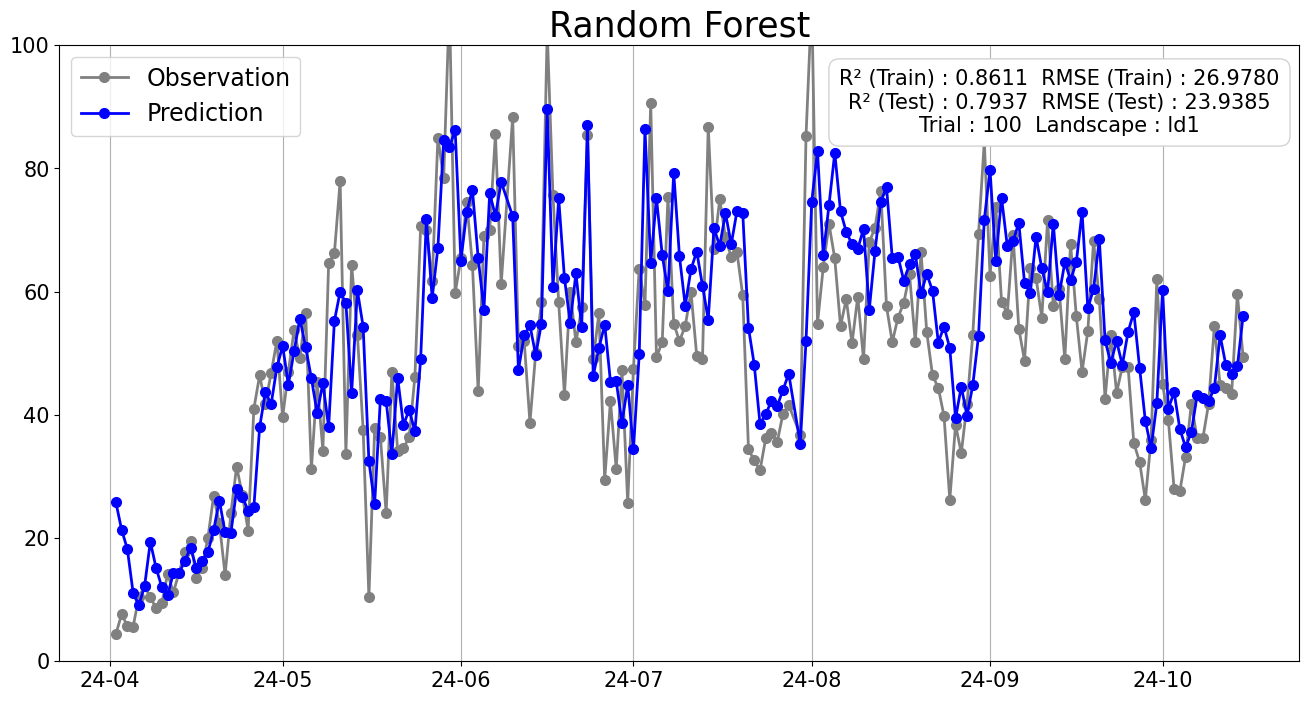

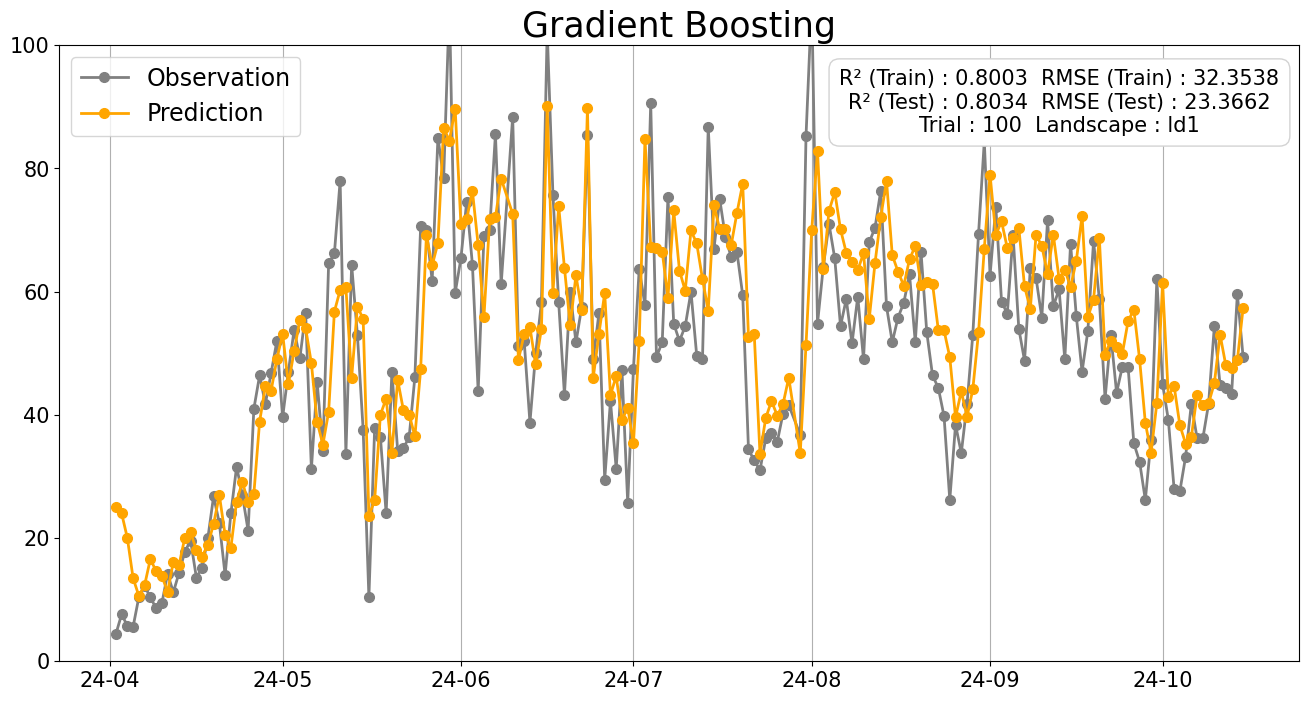

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# 📌 사용할 모델 리스트
model_names = ["lgbm", "xgb", "rf", "gb"]

# 📌 모델 이름 및 색상 딕셔너리
model_full_names = {
    "lgbm": "Light Gradient Boosting",
    "xgb": "Extreme Gradient Boosting",
    "rf": "Random Forest",
    "gb": "Gradient Boosting"
}
model_colors = {
    "lgbm": "green",
    "xgb": "red",
    "rf": "blue",
    "gb": "orange"
}

# 📌 그래프 출력 및 저장 함수
def plot_model_predictions(model_name, save=False):
    full_model_name = model_full_names.get(model_name, model_name)
    
    plt.figure(figsize=(16, 8))

    # 실제 모기 개체 수 평균값 (회색, 선 두께 증가)
    plt.plot(test_data_avg.index, test_data_avg['mosquito'], label="Observation",
             color="grey", marker='o', markersize=7, linewidth=2)

    # 예측값 평균 (선택한 모델의 색상 적용)
    plt.plot(y_pred_avg[model_name].index, y_pred_avg[model_name]['Prediction'], 
             label="Prediction", color=model_colors[model_name], marker='o', markersize=7, linewidth=2)

    # X축 포맷 설정 (월-일)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    # y축 회색 세로줄 제거 (x축만 그리드 유지)
    plt.grid(axis='x')

    # 폰트 크기 설정

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # y축 범위 강제 설정
    plt.ylim(0, 100)

    # 제목 수정: 선택한 모델의 풀네임이 나오도록 변경
    plt.title(f"{full_model_name}", fontsize=25)

    # 범례 왼쪽 상단으로 이동
    plt.legend(fontsize=17, loc='upper left')

    # 📌 R² 및 RMSE 정보 텍스트 박스 (옅은 회색 배경 + 둥근 모서리)
    textstr = (f"R² (Train) : {predictions[model_name]['train_r2']:.4f}  RMSE (Train) : {predictions[model_name]['train_rmse']:.4f}\n"
               f"R² (Test) : {predictions[model_name]['test_r2']:.4f}  RMSE (Test) : {predictions[model_name]['test_rmse']:.4f}\n"
               f"Trial : 100  Landscape : {LANDSCAPE}")

    plt.figtext(0.75, 0.85, textstr, fontsize=15, ha='center', va='top',
                bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round,pad=0.5'))

    # 모델 피클 파일 경로에서 저장 폴더 결정
    model_pkl_path = MODEL_PATHS[model_name]
    save_folder = os.path.dirname(model_pkl_path)  # 모델이 저장된 폴더
    save_filename = f"{model_name}_mean_{LANDSCAPE}.png"
    save_path = os.path.join(save_folder, save_filename)

    # 그래프 저장 옵션
    if save:
        plt.savefig(save_path, dpi=300)
        print(f"📁 그래프 저장 완료: {save_path}")

    # 그래프 출력
    plt.show()

# 📌 각 모델별 그래프 생성 (필요하면 `save=True` 추가)
for model_name in model_names:
    plot_model_predictions(model_name, save=False)
